In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Client fidelity and ranking of products - basic statistics

In [2]:
orders = pd.read_csv('data/orders.csv', sep=',')
aisles = pd.read_csv('data/aisles.csv', sep=',')
products = pd.read_csv('data/products.csv', sep=',')
history = pd.read_csv('data/order_products__prior.csv', sep=',')

In [3]:
consumptions = pd.merge(history, orders, on="order_id")
consumptions = consumptions[["order_id","user_id","add_to_cart_order","reordered","order_number","product_id"]]
consumptions["count"]=1
consumptions.head()

,order_id,user_id,add_to_cart_order,reordered,order_number,product_id,count
0,2,202279,1.0,1.0,3,33120.0,1
1,2,202279,2.0,1.0,3,28985.0,1
2,2,202279,3.0,0.0,3,9327.0,1
3,2,202279,4.0,1.0,3,45918.0,1
4,2,202279,5.0,0.0,3,30035.0,1


### 1 - Fidelity of the users

In [4]:
def get_user_fidelity(consumptions) :
    fidelity = consumptions.groupby(["user_id","product_id"]).agg({'reordered': "sum"})
    fidelity_per_user = fidelity.groupby("user_id").agg({'reordered':'mean'})
    fidelity_per_user.columns=["user_fidelity"]
    return fidelity_per_user

def reliable_user_fidelity(consumptions, min_consumptions = 3):
    nb_orders = consumptions.groupby(["user_id"]).agg({"order_number":"max"})
    fidelity_per_user = get_user_fidelity(consumptions)
    fidelity_and_reliability =pd.merge(fidelity_per_user,nb_orders, on = "user_id")
    return fidelity_and_reliability[fidelity_and_reliability.order_number >= min_consumptions]

If certain users only ordered once, it doesn't make sense to estimate theur fidelity to a product. So we filter them by selecting only the ones who ordered at least a certain number of times.

In [5]:
min_consumptions = 3
usr_fid = reliable_user_fidelity(consumptions, min_consumptions).sort_values(by='user_fidelity')
nb_reliable_users =len(usr_fid)
nb_users = max(consumptions.user_id)
print(round(nb_reliable_users*100/nb_users,2),"% of the users consumed more at least three times.")
usr_fid.head()

78.65 % of the users consumed more at least three times.


,user_fidelity,order_number
user_id,,
85198,0.0,3
27887,0.0,4
111518,0.0,10
187608,0.0,3
81071,0.0,3


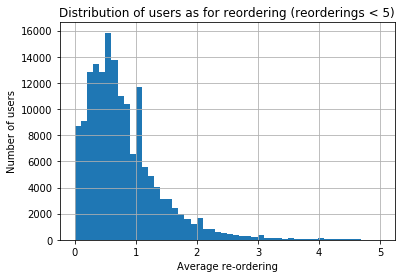

In [6]:
usr_fid[["user_fidelity"]][usr_fid<5].hist(bins=50)
ax = plt.gca()
ax.set_xlabel("Average re-ordering")
ax.set_ylabel("Number of users")
ax.set_title("Distribution of users as for reordering (reorderings < 5)")
plt.show()

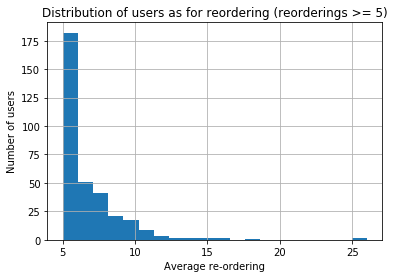

In [7]:
usr_fid[["user_fidelity"]][usr_fid>=5].hist(bins=20)
ax = plt.gca()
ax.set_xlabel("Average re-ordering")
ax.set_ylabel("Number of users")
ax.set_title("Distribution of users as for reordering (reorderings >= 5)")
plt.show()

Most users consume on average less than one time a product. We observe big peaks at 0, 1/2, 1 and 2, which must correspond to users who consumed rarely.

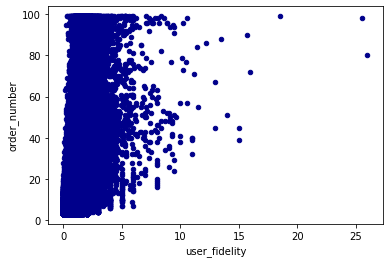

In [8]:
ax1 = usr_fid.plot.scatter(x='user_fidelity', y='order_number',c='DarkBlue')

Surprisingly enough, consumers who reorder the most on average are among the greatest consumers.

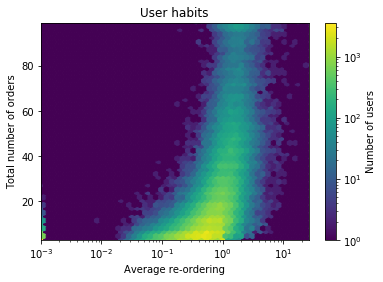

In [9]:
def plot_usr_fid(usr_fid):
    x = np.array(usr_fid.user_fidelity)+0.001
    y= np.array(usr_fid.order_number)
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50, bins='log', xscale='log')
    ax.set(xlim=(0.001, max(x)), ylim=(min_consumptions, max(y)))
    ax.set_title("User habits")
    ax.set_xlabel("Average re-ordering")
    ax.set_ylabel("Total number of orders")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_usr_fid(usr_fid)

Most users only ordered a few times, and small 
Above a certain number of orders, the average re-ordering can't be too low, which can be explained by the fact that people who buy so much either already have tried all the products, or (more likely) have strong consumption habits.

### 2 - Product "fidelity score"

Now, for one given product, we would like to know if users appreciate it in general, that is their average fidelity to this given product. But this should be normalized by the average fidelity of each user ! If a product has been consumed only by 1 particular user who bought it thrice but usually buys  products 10 times, we don't want it to get a great score.

In [10]:
def get_addictivities(consumptions):
    consumptions["prod_id"]=consumptions["product_id"]
    fidelity = consumptions.groupby(["user_id","prod_id"]).agg({'reordered': "sum","product_id":"mean"})
    fidelity_per_user = get_user_fidelity(fidelity)    
    # Get fidelity table together with average user fidelity
    with_user_fidelity = pd.merge(fidelity, fidelity_per_user[fidelity_per_user.user_fidelity>0], on="user_id")
    # Normalize fidelity to one product by user fidelity
    with_user_fidelity["appreciation_per_user"] = with_user_fidelity.reordered/with_user_fidelity.user_fidelity
    return with_user_fidelity.groupby("product_id").agg({"appreciation_per_user":"mean"})

fidelity_scores = get_addictivities(consumptions)
fidelity_scores.sort_values("appreciation_per_user").tail()

,appreciation_per_user
product_id,
17226.0,10.333333
40891.0,10.600000
22670.0,12.000000
23097.0,12.666667
21279.0,18.000000


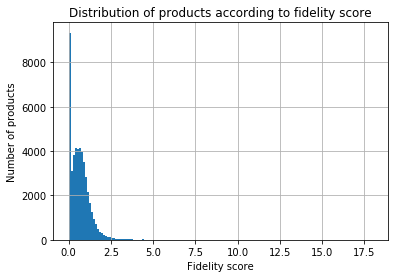

In [11]:
fidelity_scores.hist(bins=150)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score")
plt.show()

We observe that most values (whose weighted average over consumptions should be one !) are in the interval [0, 2] with a great peak at 0.

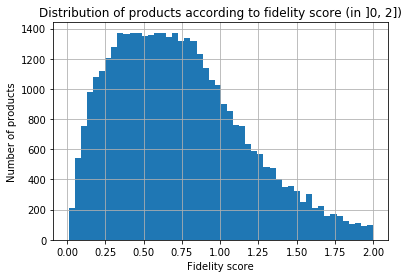

In [12]:
fidelity_scores_less5 = fidelity_scores[fidelity_scores.appreciation_per_user<2]
fidelity_scores_less5[0<fidelity_scores_less5.appreciation_per_user].hist(bins=50)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score (in ]0, 2])")
plt.show()

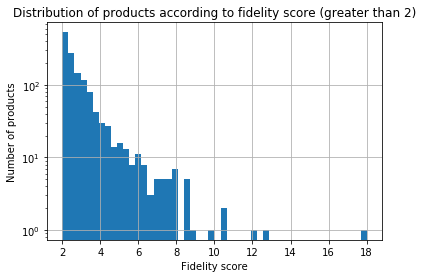

In [13]:
fidelity_scores_more5 = fidelity_scores[fidelity_scores.appreciation_per_user>=2]
fidelity_scores_more5.hist(bins=50, log=True)
ax = plt.gca()
ax.set_xlabel("Fidelity score")
ax.set_ylabel("Number of products")
ax.set_title("Distribution of products according to fidelity score (greater than 2)")
plt.show()

Let's confront those values to the reliability of each score, that corresponds to the number of times the product was bought.

In [14]:
# Add the weight of each product
product_weights = consumptions.groupby("product_id").agg({"count":"sum"})
fidelity_scores_weights = pd.merge(product_weights, fidelity_scores, on= "product_id")
fidelity_scores_weights.head()

,count,appreciation_per_user
product_id,,
1.0,507,0.679629
2.0,21,0.093217
3.0,62,1.630632
4.0,90,0.975122
5.0,4,1.829932


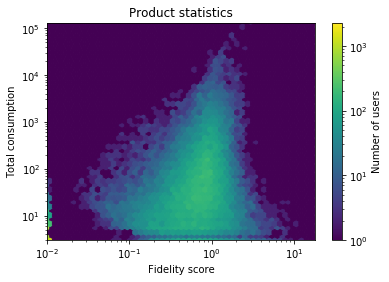

In [15]:
def plot_scores_weights(fidelity_scores):
    x = np.array(fidelity_scores.appreciation_per_user)+0.01
    y = np.array(fidelity_scores["count"])
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50, bins='log', xscale='log', yscale='log')
    ax.set(xlim=(0.01, max(x)), ylim=(min_consumptions, max(y)))
    ax.set_title("Product statistics")
    ax.set_xlabel("Fidelity score")
    ax.set_ylabel("Total consumption")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_scores_weights(fidelity_scores_weights)

We can't see a very clear correlation. Nevertheless, we can remark 2 things.

1 - Most consumed products overall are on average better-liked than others (score greater than 1).

2 - A great number of products was only bought once by a less than a dozen of users.

### 3 - Average score per aisle

We might think about averaging the scores of products present in each aisle, but some of them may be undefined, and some products might be much more consumed than others. Again we have to put some weights.

In [16]:
def get_aisle_scores(fidelity_scores_weights, products, aisles):
    scores_with_aisles = pd.merge(fidelity_scores_weights, products, on ="product_id")
    scores_with_aisles["total_appreciation"]= scores_with_aisles.appreciation_per_user * scores_with_aisles["count"]
    aisle_scores = scores_with_aisles.groupby("aisle_id").agg({"total_appreciation":"sum","count":"sum"})
    aisle_scores["average_appreciation"] = aisle_scores.total_appreciation / aisle_scores["count"]
    aisle_scores_labelled = pd.merge(aisles, aisle_scores, on="aisle_id")
    return aisle_scores_labelled

aisle_scores_labelled = get_aisle_scores(fidelity_scores_weights, products, aisles)
aisle_scores_labelled.sort_values(by="average_appreciation", ascending=False).head(20)

,aisle_id,aisle,total_appreciation,count,average_appreciation
83,84,milk,5.041101e+05,247161,2.039602
114,115,water seltzer sparkling water,3.877947e+05,232414,1.668551
61,62,white wines,1.410749e+04,8469,1.665780
23,24,fresh fruits,1.614193e+06,1012021,1.595020
85,86,eggs,1.998489e+05,125697,1.589926
123,124,spirits,1.147760e+04,7638,1.502696
90,91,soy lactosefree,2.641234e+05,177179,1.490715
52,53,cream,1.270197e+05,88104,1.441702
76,77,soft drinks,1.352864e+05,99233,1.363321
63,64,energy sports drinks,3.895822e+04,28715,1.356720


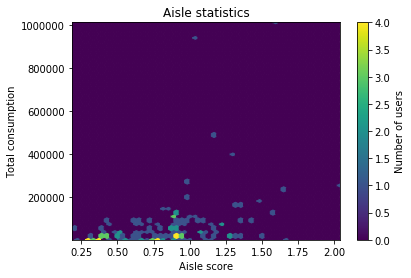

In [17]:
def plot_aisle_scores(aisle_scores):
    x = np.array(aisle_scores.average_appreciation)
    y = np.array(aisle_scores["count"])
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=50)#, xscale='log', yscale='log')
    ax.set(xlim=(min(x), max(x)), ylim=(min(y), max(y)))
    ax.set_title("Aisle statistics")
    ax.set_xlabel("Aisle score")
    ax.set_ylabel("Total consumption")
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label('Number of users')    
    plt.show()
    
plot_aisle_scores(aisle_scores_labelled)

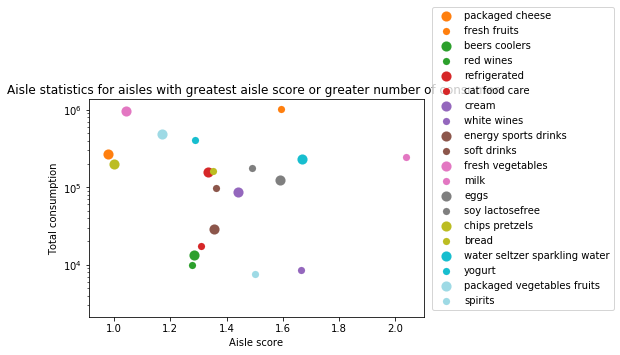

In [18]:
from matplotlib.cm import tab20
from matplotlib.colors import rgb2hex 

# create a scatterplot function
def scatter_plot(df,x_axis, y_axis, l_axis, x_legend, y_legend, title, y_log_scale = False) :
    '''Plots the variables x_axis, y_axis stored in columns of the dataframe df. The legend is from the column l_axis of the datframe. The other parameters have obvious names.'''
    fig, ax = plt.subplots()
    nb=0
    for i in range(df.shape[0]):
        x = df[x_axis][i]
        y = float(df[y_axis][i])
        l = df[l_axis][i]
        if x>1.25 or y>150000 :
            nb+=1
            # We use a categorical colormap to identify clearly the different subreddits
            ax.scatter(x, y, label=l, s=50*(1+nb%2), linewidth=0.1, c=rgb2hex(tab20(round(nb+1/2))))
    ax.legend(loc="lower left", bbox_to_anchor= (1.01, 0.01), ncol=1)
    if y_log_scale : ax.set_yscale('log')
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.title(title)
    plt.show()
    
scatter_plot(aisle_scores_labelled,"average_appreciation","count","aisle","Aisle score","Total consumption", "Aisle statistics for aisles with greatest aisle score or greater number of consumers",True)

### 4 - Healthiness comes in the game

In [19]:
f = open("good_users_cluster.pk","rb")
users_cluster = pickle.load(f)
f.close()
dict_cluster = {}
for (user, cluster) in enumerate(users_cluster):
    dict_cluster[user+1] = cluster   # users_cluster[i] = cluster of user whose id is i+1
users = pd.DataFrame.from_dict(dict_cluster, orient='index')
users.columns=["cluster_id"]
users["user_id"] = users.index

In [20]:
consumption_clusters = pd.merge(consumptions[["order_id","product_id","user_id","count"]], users, on="user_id")
per_product = consumption_clusters.groupby(["product_id","user_id"]).agg({"count":"sum","cluster_id":"mean"})

In [22]:
per_product["healthiness_score"] = cluster_to_coeff(per_product.cluster_id)
per_product["total_healthiness_score"] = per_product.healthiness_score * per_product["count"]
healthiness_per_product = per_product.groupby("product_id").agg({"count":"sum","total_healthiness_score":"sum"})
healthiness_per_product["average_healthiness"] = healthiness_per_product.total_healthiness_score / healthiness_per_product["count"]

In [25]:
def cluster_to_coeff(cluster_id):
    return -0.5*(cluster_id-1)*(cluster_id-2)-cluster_id*(cluster_id-2) + 2*cluster_id*(cluster_id-1)
# Maps 0 to -1, 1 to 1 and 2 to 4

In [23]:
healthiness_per_product[["average_healthiness"]].head()

,average_healthiness
product_id,
1.0,2.739645
2.0,0.333333
3.0,1.338710
4.0,3.111111
5.0,-0.500000


In [27]:
final_data_products = pd.merge(healthiness_per_product[["average_healthiness"]],fidelity_scores_weights, on="product_id")

In [29]:
final_data_products.head(20)

,average_healthiness,count,appreciation_per_user
product_id,,,
1.0,2.739645,507,0.679629
2.0,0.333333,21,0.093217
3.0,1.338710,62,1.630632
4.0,3.111111,90,0.975122
5.0,-0.500000,4,1.829932
6.0,1.500000,4,0.565657
7.0,0.800000,5,0.507500
8.0,2.465116,43,0.835184
9.0,1.400000,45,0.803593


In [30]:
final_data_products.to_pickle("product_scores")